In [12]:
%matplotlib inline
from detector import Detector
from utils import draw_bounding_boxes

In [13]:
test_image = "/home/louis/datasets/wider_face/WIDER_test/images/37--Soccer/37_Soccer_soccer_ball_37_780.jpg"
state_file = "/media/louis/ext4/models/sfd/models/epoch_43.pth.tar"

In [14]:
detector = Detector(state_file)

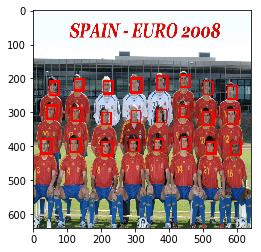

In [15]:
bboxes = detector.infer(test_image)
draw_bounding_boxes(test_image, bboxes)